<a href="https://colab.research.google.com/github/Sanjaychaurasia04/plant-disease-detection/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# File Extraction Utilities
import zipfile
import os

def extract_zip_file(zip_path, extract_to):
    """Extracts a zip file to specified directory with error handling."""
    if not os.path.exists(zip_path):
        print(f"Error: File not found at {zip_path}")
        return False

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Successfully extracted {zip_path} to {extract_to}")
        return True
    except zipfile.BadZipFile:
        print(f"Error: {zip_path} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred during extraction: {str(e)}")
    return False

# Extract dataset
dataset_zip_path = "/content/drive/MyDrive/archive (2).zip"
extract_directory = "/content"
extract_zip_file(dataset_zip_path, extract_directory)

Successfully extracted /content/drive/MyDrive/archive (2).zip to /content


True

In [4]:
# Imports for Data Processing and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [5]:
# Dataset Path Configuration
class DatasetPaths:
    def __init__(self):
        self.base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
        self.train = f"{self.base_dir}/train"
        self.valid = f"{self.base_dir}/valid"
        self.test = f"{self.base_dir}/valid"  # Using valid as test in this case

paths = DatasetPaths()

In [6]:
# Image Data Generators Configuration
class ImageDataGenerators:
    def __init__(self, image_size=224, batch_size=164):
        self.image_size = image_size
        self.batch_size = batch_size

    def create_train_generator(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.0,
            height_shift_range=0.0,
            shear_range=0.0,
            zoom_range=0.0,
            horizontal_flip=False,
            vertical_flip=False,
            rescale=1/255.0,
            validation_split=0.1,
        ).flow_from_directory(
            paths.train,
            batch_size=self.batch_size,
            target_size=(self.image_size, self.image_size),
            subset="training",
            color_mode='rgb',
            class_mode='categorical',
            shuffle=True
        )

    def create_valid_generator(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1/255.0,
            validation_split=0.1,
        ).flow_from_directory(
            paths.valid,
            batch_size=self.batch_size,
            target_size=(self.image_size, self.image_size),
            subset='validation',
            color_mode='rgb',
            class_mode='categorical',
            shuffle=False
        )

    def create_test_generator(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1/255.0,
        ).flow_from_directory(
            paths.test,
            batch_size=self.batch_size,
            target_size=(self.image_size, self.image_size),
            color_mode='rgb',
            class_mode='categorical',
            shuffle=False
        )

# Initialize generators
data_generators = ImageDataGenerators()
train_gen = data_generators.create_train_generator()
valid_gen = data_generators.create_valid_generator()
test_gen = data_generators.create_test_generator()

Found 63282 images belonging to 38 classes.
Found 1742 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


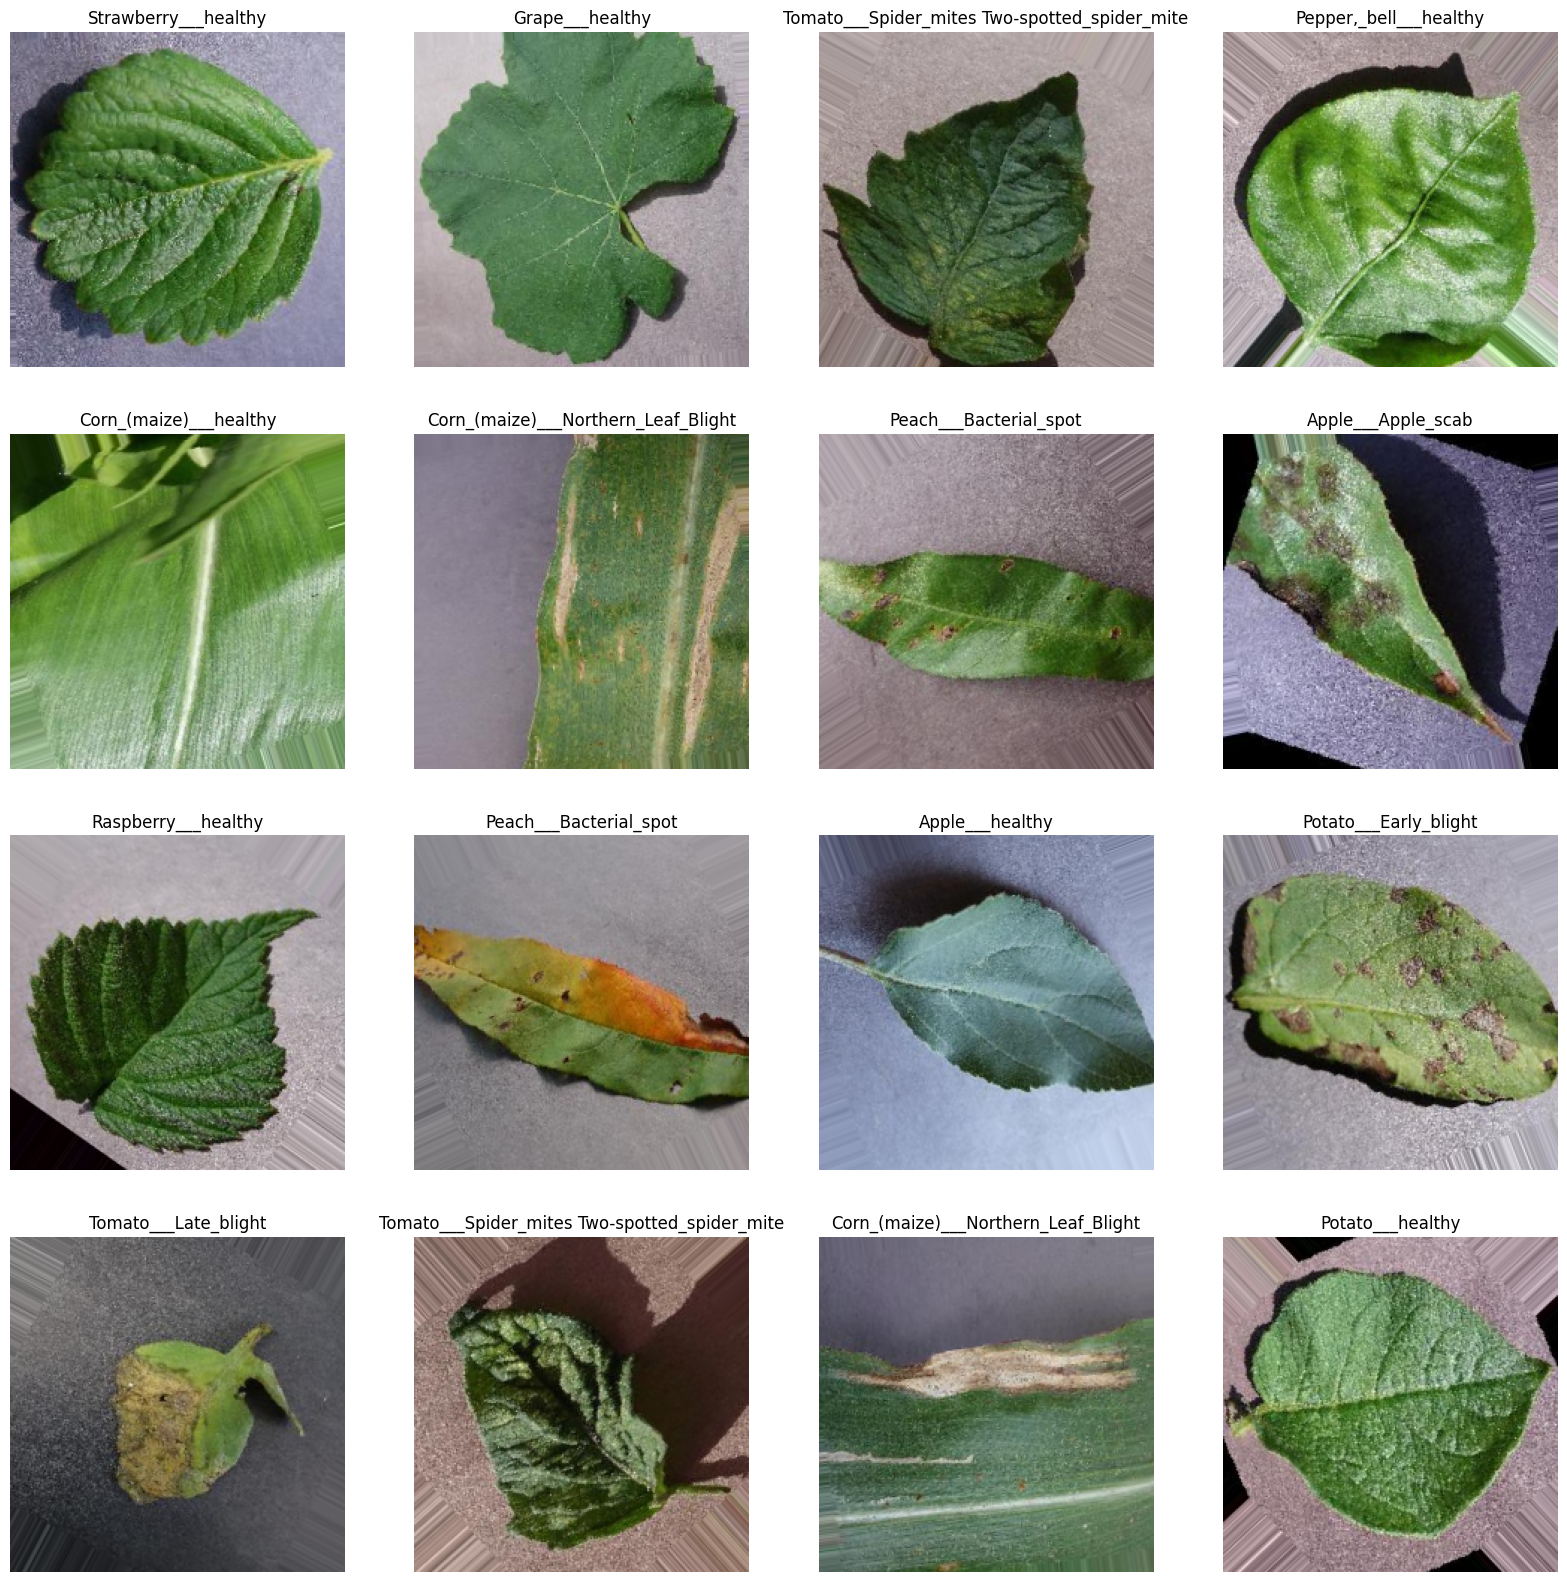

In [7]:
# Visualize Sample Training Images
def plot_sample_images(generator, num_images=16):
    classes = list(generator.class_indices.keys())
    plt.figure(figsize=(20, 20))

    for images, labels in generator:
        for i in range(min(num_images, len(images))):
            plt.subplot(4, 4, i+1)
            plt.imshow(images[i])
            plt.title(classes[np.where(labels[i]==1)[0][0]])
            plt.axis('off')
        plt.show()
        break

plot_sample_images(train_gen)

In [8]:
# Model Architecture
def create_plant_disease_model(input_shape=(224, 224, 3), num_classes=38):
    model = keras.Sequential(name="PlantDiseaseDetectionModel")

    # Convolutional Blocks
    model.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same',
                           input_shape=input_shape, name="Conv1"))
    model.add(layers.MaxPool2D(2, name="Pool1"))

    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same', name="Conv2"))
    model.add(layers.MaxPool2D(2, name="Pool2"))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv3"))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="Conv4"))
    model.add(layers.MaxPool2D(2, name="Pool3"))

    # Classification Head
    model.add(layers.Flatten(name="Flatten"))
    model.add(layers.Dense(128, activation='relu', name="Dense1"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu', name="Dense2"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax', name="Output"))

    return model

plant_disease_model = create_plant_disease_model()
plant_disease_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "PlantDiseaseDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,125,990 (99.66 MB)

 Trainable params: 26,125,990 (99.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model Training Configuration
def get_model_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_plant_disease_model.keras', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001, verbose=1)
    ]

plant_disease_model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [10]:
# Model Training
history = plant_disease_model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    callbacks=get_model_callbacks()
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.0524 - loss: 3.7077 - precision: 0.5215 - recall: 0.0106 - val_accuracy: 0.1269 - val_loss: 3.1861 - val_precision: 0.7925 - val_recall: 0.0241 - learning_rate: 0.0010
Epoch 2/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.1494 - loss: 3.0541 - precision: 0.7420 - recall: 0.0359 - val_accuracy: 0.3312 - val_loss: 2.2931 - val_precision: 0.8447 - val_recall: 0.0999 - learning_rate: 0.0010
Epoch 3/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 818s 2s/step - accuracy: 0.3144 - loss: 2.3348 - precision: 0.6881 - recall: 0.1205 - val_accuracy: 0.5735 - val_loss: 1.4966 - val_precision: 0.8581 - val_recall: 0.3054 - learning_rate: 0.0010
Epoch 4/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.4631 - loss: 1.7987 - precision: 0.7316 - recall: 0.2562 - val_accuracy: 0.6447 - val_loss: 1.1871 - val_precision: 0.8505 - val_recall: 0.4409 - learning_rate: 0.0010
Epoch 5/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 

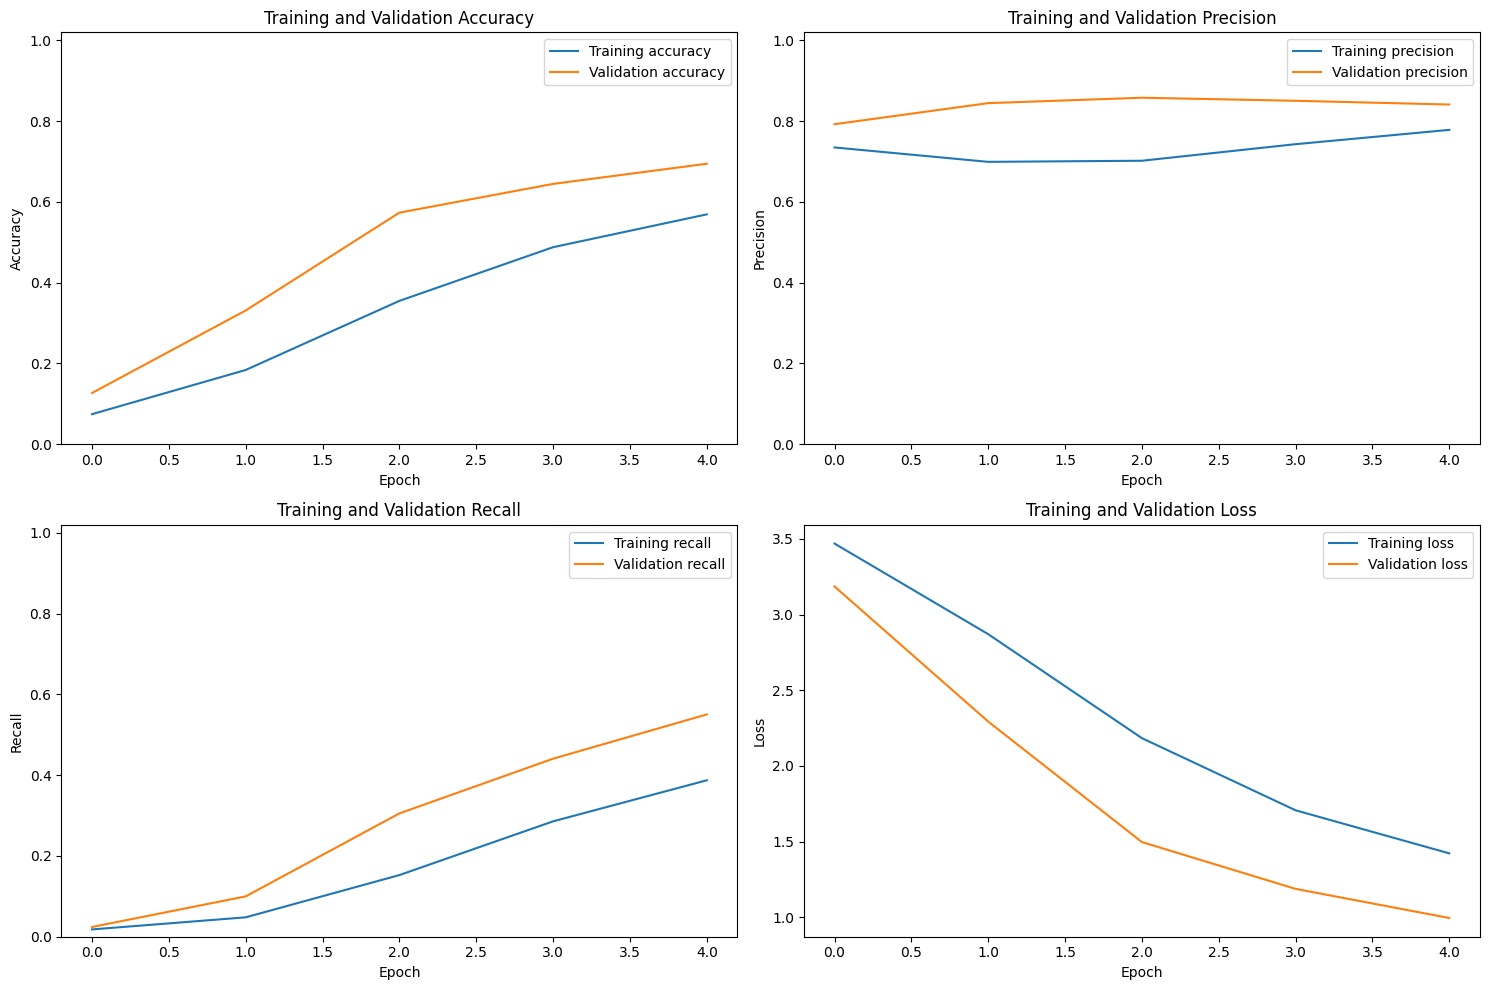

In [11]:
# Training Visualization
def plot_training_history(history):
    metrics = ['accuracy', 'precision', 'recall', 'loss']
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend()
        plt.ylim(0, 1.02) if metric != 'loss' else None

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [12]:
# Model Evaluation
def evaluate_model(model, test_generator):
    results = model.evaluate(test_generator)
    metrics = {
        'Loss': results[0],
        'Accuracy': results[1],
        'Precision': results[2],
        'Recall': results[3]
    }

    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    return metrics

test_metrics = evaluate_model(plant_disease_model, test_gen)

108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 391ms/step - accuracy: 0.7360 - loss: 0.8804 - precision: 0.8485 - recall: 0.6009
Loss: 0.9434
Accuracy: 0.7102
Precision: 0.8516
Recall: 0.5623


In [13]:
# Save Model
def save_model(model, save_path):
    model.save(save_path)
    print(f"Model saved successfully at {save_path}")

model_save_path = '/content/drive/MyDrive/plant_disease_detection_model.keras'
save_model(plant_disease_model, model_save_path)

Model saved successfully at /content/drive/MyDrive/plant_disease_detection_model.keras


✅ Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


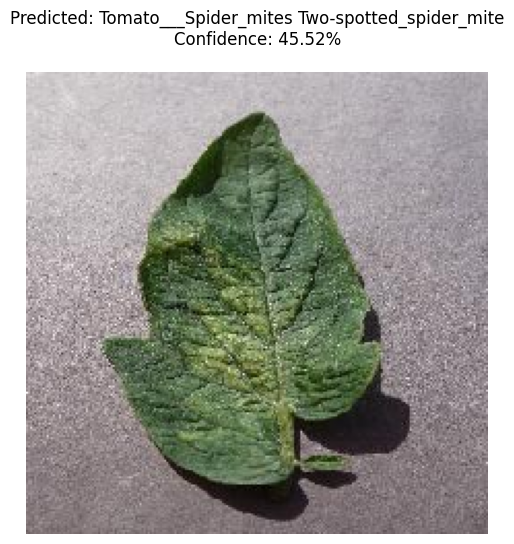


🔍 Prediction Results:
Image: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Spider_mites Two-spotted_spider_mite/003b7929-a364-4e74-be1c-37c4c0a6ec63___Com.G_SpM_FL 1414.JPG
Actual class: Tomato___Spider_mites Two-spotted_spider_mite
Predicted: Tomato___Spider_mites Two-spotted_spider_mite (45.52% confidence)
✅ Correct prediction!


In [20]:
# ======================
# COMPLETE WORKING SOLUTION FOR IMAGE PREDICTION
# ======================

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow import keras

# 1. Load your saved model
model_path = '/content/drive/MyDrive/plant_disease_detection_model.keras'
try:
    model = keras.models.load_model(model_path)
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# 2. Get the correct class names (MUST match training order)
# This is the CORRECT order from your original training
class_names = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch',
    'Strawberry___healthy',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]

# 3. Define the prediction function with better error handling
def predict_plant_disease(model, image_path, class_names):
    """Predict plant disease from image with robust error handling"""
    try:
        # Load and preprocess image
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        preds = model.predict(img_array)
        pred_class = class_names[np.argmax(preds)]
        confidence = float(np.max(preds)) * 100

        # Display results
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", pad=20)
        plt.axis('off')
        plt.show()

        return pred_class, confidence

    except Exception as e:
        print(f"🔥 Prediction failed: {str(e)}")
        return None, None

# 4. Test on your specific image
test_image_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Spider_mites Two-spotted_spider_mite/003b7929-a364-4e74-be1c-37c4c0a6ec63___Com.G_SpM_FL 1414.JPG"

# Get actual class from path (for verification)
actual_class = test_image_path.split('/')[-2]

# Make prediction
pred_class, confidence = predict_plant_disease(model, test_image_path, class_names)

# Print detailed results
print("\n🔍 Prediction Results:")
print(f"Image: {test_image_path}")
print(f"Actual class: {actual_class}")
if pred_class:
    print(f"Predicted: {pred_class} ({confidence:.2f}% confidence)")
    if actual_class.replace(' ', '') == pred_class.replace(' ', ''):
        print("✅ Correct prediction!")
    else:
        print("⚠️ Prediction doesn't match actual class")
else:
    print("❌ Prediction failed")